# CSV → Graphs (Quick Start)

Use this notebook to load any CSV and generate quick visualizations.

## How to use
1. Put your CSV file in the same folder as this notebook.
2. In **Step 2**, change `csv_path` to your filename (e.g., `"my_data.csv"`).
3. Run the cells from top to bottom.
4. Use the helper functions in **Step 4** to make the charts you want.

**Tip:** If your data comes from Apple Numbers, export as `File → Export To → CSV…` first.

In [33]:
# Step 1 — Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
print('Versions → pandas', pd.__version__, '| numpy', np.__version__)

Versions → pandas 2.3.2 | numpy 2.3.2


In [34]:
# Step 2 — Load your CSV
csv_path = 'energy_log_20250829_120521_521_cpu1.csv'  # ← CHANGE THIS to your file name, e.g., 'energy.csv'

def smart_read_csv(path):
    """Read CSV and auto-detect common date columns."""
    df = pd.read_csv(path)
    # Try to parse likely date/time columns
    for col in df.columns:
        if df[col].dtype == object:
            try:
                s = pd.to_datetime(df[col], errors='raise', utc=False)
                # Heuristic: if at least 80% of non-null values parsed, keep it
                ok_ratio = s.notna().mean() if len(s) else 0
                if ok_ratio >= 0.8:
                    df[col] = s
            except Exception:
                pass
    return df

df = smart_read_csv(csv_path)
print('Rows:', len(df), '| Columns:', len(df.columns))
df.head()

Rows: 3600 | Columns: 6


,Timestamp (ISO ms),Voltage (V),Current (A),Power (W),dt (s),Energy So Far (J)
0,2025-08-29 12:05:21.546,0.879731,0.86621,0.762032,0.000000,0.000000
1,2025-08-29 12:05:21.644,0.879193,0.86621,0.761566,0.099962,0.076127
2,2025-08-29 12:05:21.744,0.879193,0.86621,0.761566,0.099992,0.152278
3,2025-08-29 12:05:21.844,0.878925,0.86621,0.761333,0.099999,0.228411
4,2025-08-29 12:05:21.944,0.879193,0.85728,0.753715,0.100000,0.303782


In [35]:
# Step 3 — Quick overview (compatible with old/new pandas)
import inspect

try:
    # Prefer using datetime_is_numeric if this pandas supports it
    sig = inspect.signature(type(df).describe)
    if "datetime_is_numeric" in sig.parameters:
        display(df.describe(include='all', datetime_is_numeric=True))
    else:
        display(df.describe(include='all'))
except TypeError:
    # Fallback for older pandas that doesn't accept the arg
    display(df.describe(include='all'))

df.info()

,Timestamp (ISO ms),Voltage (V),Current (A),Power (W),dt (s),Energy So Far (J)
count,3600,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,2025-08-29 12:08:21.494127616,0.838676,1.217462,1.046315,0.099972,176.485632
min,2025-08-29 12:05:21.546000,0.747032,0.544730,0.407809,0.000000,0.000000
25%,2025-08-29 12:06:51.519000064,0.749718,0.616170,0.461292,0.099999,57.115431
50%,2025-08-29 12:08:21.494500096,0.879193,0.928720,0.816275,0.100000,160.040768
75%,2025-08-29 12:09:51.469250048,0.879462,1.723490,1.515281,0.100001,298.556006
max,2025-08-29 12:11:21.444000,0.881074,3.286240,2.889240,0.102799,376.597977
std,NaN,0.059773,0.626094,0.574595,0.001670,126.750036


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Timestamp (ISO ms)  3600 non-null   datetime64[ns]
 1   Voltage (V)         3600 non-null   float64       
 2   Current (A)         3600 non-null   float64       
 3   Power (W)           3600 non-null   float64       
 4   dt (s)              3600 non-null   float64       
 5   Energy So Far (J)   3600 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 168.9 KB


In [36]:
# Step 4 — Plot helpers (pick and use the ones you need)

def numeric_cols(dataframe):
    return dataframe.select_dtypes(include=[np.number]).columns.tolist()

def datetime_cols(dataframe):
    return dataframe.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()

def line_over_time(dataframe, time_col=None, y_cols=None, title='Line over time'):
    """Plot one or more numeric columns against a time column."""
    if time_col is None:
        dcols = datetime_cols(dataframe)
        if not dcols:
            raise ValueError('No datetime-like column found. Specify time_col.')
        time_col = dcols[0]
    if y_cols is None:
        y_cols = numeric_cols(dataframe)
    if not y_cols:
        raise ValueError('No numeric columns to plot.')
    for col in y_cols:
        plt.figure()
        dataframe.plot(x=time_col, y=col, kind='line', legend=False)
        plt.title(f"{title}: {col}")
        plt.xlabel(time_col)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

def bar_top_n(dataframe, by_col, value_col, n=10, ascending=False, title='Top N'):
    """Bar chart of top N categories by a numeric value."""
    tmp = dataframe[[by_col, value_col]].dropna()
    agg = tmp.groupby(by_col, dropna=False)[value_col].sum().sort_values(ascending=ascending)
    top = agg.head(n)
    plt.figure()
    top.plot(kind='bar')
    plt.title(f"{title}: {value_col} by {by_col}")
    plt.xlabel(by_col)
    plt.ylabel(value_col)
    plt.tight_layout()
    plt.show()

def histograms(dataframe, bins=30):
    """One histogram per numeric column."""
    for col in numeric_cols(dataframe):
        plt.figure()
        dataframe[col].dropna().plot(kind='hist', bins=bins)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

def scatter(dataframe, x, y, title=None):
    plt.figure()
    dataframe.plot(kind='scatter', x=x, y=y)
    plt.title(title or f"Scatter: {x} vs {y}")
    plt.tight_layout()
    plt.show()

def correlation_heatmap(dataframe):
    """Simple correlation heatmap using matplotlib only (no seaborn)."""
    num = dataframe[numeric_cols(dataframe)]
    corr = num.corr(numeric_only=True)
    fig = plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation='nearest')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar()
    plt.title('Correlation heatmap')
    plt.tight_layout()
    plt.show()

print('Helpers ready. See examples below ↓')

Helpers ready. See examples below ↓


In [37]:
# 4.1
# Auto-choose a likely categorical and numeric column
import numpy as np

def guess_columns_for_topn(df, max_cardinality=50):
    cat_candidates = [c for c in df.select_dtypes(exclude=np.number).columns
                      if df[c].nunique(dropna=True) <= max_cardinality]
    num_candidates = df.select_dtypes(include=np.number).columns.tolist()
    by_col = cat_candidates[0] if cat_candidates else None
    value_col = num_candidates[0] if num_candidates else None
    return by_col, value_col

by_col, value_col = guess_columns_for_topn(df)
print("Guessed by_col:", by_col, "| value_col:", value_col)

if by_col and value_col:
    bar_top_n(df, by_col=by_col, value_col=value_col, n=10, title=f"Top {by_col} by {value_col}")
else:
    print("Could not guess suitable columns. Show columns with df.columns.tolist() and pick manually.")

Guessed by_col: None | value_col: Voltage (V)
Could not guess suitable columns. Show columns with df.columns.tolist() and pick manually.


In [38]:
# Step 4.2 — Plot helpers (keep as is)

# ---- New cell: Clean column names ----
def clean_columns(dataframe):
    df2 = dataframe.copy()
    df2.columns = (
        df2.columns
          .str.strip()
          .str.replace(r"\s+\(.*?\)", "", regex=True)  # drop units in parentheses
          .str.replace(r"[^0-9a-zA-Z_]+", "_", regex=True)  # spaces/symbols -> _
          .str.lower()
    )
    return df2

dfc = clean_columns(df)
print(dfc.columns.tolist())  # check simplified names

['timestamp', 'voltage', 'current', 'power', 'dt', 'energy_so_far']


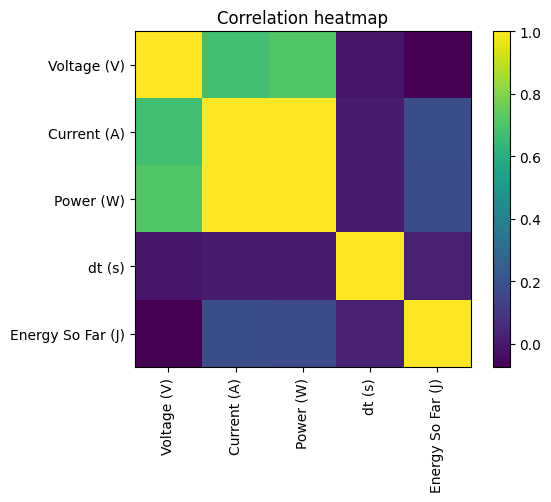

In [40]:
# Step 5 — Examples (uncomment the ones you want)

# Example A: line plots for each numeric column over first datetime column
#line_over_time(df)      # line plots for numeric columns over datetime
#histograms(df, bins=30) # histograms for numeric columns
#correlation_heatmap(df) # correlation heatmap

# Example B: top 10 categories by a value column
# Line plots of numeric values over time
#line_over_time(df)

# Histograms of each numeric column
#histograms(df, bins=30)

# Correlation heatmap between numeric columns
#correlation_heatmap(df)

# Scatter between two chosen numeric columns
#scatter(df, x='Voltage (V)', y='Current (A)', title='Voltage vs Current')

# Example C: histograms for all numeric columns
#histograms(df, bins=30)

# Example D: scatter between two numeric columns
# Line plots
#line_over_time(dfc)

# Histograms
#histograms(dfc, bins=30)

# Correlation heatmap
#correlation_heatmap(dfc)

#Inspect the actual column names (including hidden characters)
#print("COLUMNS:", dfc.columns.tolist())
#for c in dfc.columns:
   # print("-", repr(c))  # shows hidden spaces or odd characters

# Scatter with clean names
#scatter(dfc, x='voltage', y='current', title='Voltage vs Current')

# Example E: correlation heatmap of numeric columns
#correlation_heatmap(df)

### Notes
- If your date column wasn't auto-detected, set it manually: `df['timestamp'] = pd.to_datetime(df['timestamp'])`.
- If your CSV uses `;` as separator, use: `pd.read_csv(csv_path, sep=';')`.
- If you have decimals with commas (e.g., `"3,14"`), add `decimal=','` to `read_csv`.